# Aarhus University - Fall 2023 - Macro-Energy System Modelling (MESM) project 

This notebook includes the steps to optimize the capacity and dispatch of generators in the power system of one country.
Make sure that you understand every step in this notebook. For the project of the course Macro-Energy System Modelling (MESM) you need to deliver a report including the sections described at the end of this notebook.

In [20]:
import pypsa

Pandas package is very useful to work with imported data, time series, matrices ...

You can find a 10-minutes guide to pandas in the following link
https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html

In [21]:
import pandas as pd

We start by creating the network. In this example, the country is modelled as a single node, so the network will only include one bus.

We select the year 2015 and set the hours in that year as snapshots.

We select a country, in this case Spain (ESP), and add one node (electricity bus) to the network.

In [22]:
network = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01T00:00Z','2015-12-31T23:00Z', freq='H')
network.set_snapshots(hours_in_2015)

network.add("Bus","electricity bus")

network.snapshots

DatetimeIndex(['2015-01-01 00:00:00+00:00', '2015-01-01 01:00:00+00:00',
               '2015-01-01 02:00:00+00:00', '2015-01-01 03:00:00+00:00',
               '2015-01-01 04:00:00+00:00', '2015-01-01 05:00:00+00:00',
               '2015-01-01 06:00:00+00:00', '2015-01-01 07:00:00+00:00',
               '2015-01-01 08:00:00+00:00', '2015-01-01 09:00:00+00:00',
               ...
               '2015-12-31 14:00:00+00:00', '2015-12-31 15:00:00+00:00',
               '2015-12-31 16:00:00+00:00', '2015-12-31 17:00:00+00:00',
               '2015-12-31 18:00:00+00:00', '2015-12-31 19:00:00+00:00',
               '2015-12-31 20:00:00+00:00', '2015-12-31 21:00:00+00:00',
               '2015-12-31 22:00:00+00:00', '2015-12-31 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='snapshot', length=8760, freq='H')

The demand is represented by the historical electricity demand in 2015 with hourly resolution. 

The file with historical hourly electricity demand for every European country is available in the data folder.

The electricity demand time series were obtained from ENTSOE through the very convenient compilation carried out by the Open Power System Data (OPSD). https://data.open-power-system-data.org/time_series/

In [23]:
# load electricity demand data
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime
print(df_elec['ESP'].head())

utc_time
2015-01-01 00:00:00+00:00    24382.0
2015-01-01 01:00:00+00:00    22734.0
2015-01-01 02:00:00+00:00    21286.0
2015-01-01 03:00:00+00:00    20264.0
2015-01-01 04:00:00+00:00    19905.0
Name: ESP, dtype: float64


In [24]:
# add load to the bus
network.add("Load",
            "load", 
            bus="electricity bus", 
            p_set=df_elec['ESP'])

Print the load time series to check that it has been properly added (you should see numbers and not 'NaN')

In [25]:
network.loads_t.p_set

Load,load
snapshot,
2015-01-01 00:00:00+00:00,24382.0
2015-01-01 01:00:00+00:00,22734.0
2015-01-01 02:00:00+00:00,21286.0
2015-01-01 03:00:00+00:00,20264.0
2015-01-01 04:00:00+00:00,19905.0
...,...
2015-12-31 19:00:00+00:00,28653.0
2015-12-31 20:00:00+00:00,27078.0
2015-12-31 21:00:00+00:00,24565.0


In the optimization, we will minimize the annualized system costs.

We will need to annualize the cost of every generator, we build a function to do it.

In [26]:
def annuity(n,r):
    """Calculate the annuity factor for an asset with lifetime n years and
    discount rate of r, e.g. annuity(20,0.05)*20 = 1.6"""

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n


We include solar PV and onshore wind generators. 

The capacity factors representing the availability of those generators for every European country can be downloaded from the following repositories (select 'optimal' for PV and onshore for wind). 

https://zenodo.org/record/3253876#.XSiVOEdS8l0

https://zenodo.org/record/2613651#.XSiVOkdS8l0

We include also Open Cycle Gas Turbine (OCGT) generators

The cost assumed for the generators are the same as in the paper https://doi.org/10.1016/j.enconman.2019.111977 (open version:  https://arxiv.org/pdf/1906.06936.pdf)

In [27]:
# add the different carriers, only gas emits CO2
network.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
network.add("Carrier", "onshorewind")
network.add("Carrier", "solar")

# add onshore wind generator
df_onshorewind = pd.read_csv('data_extra/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
CF_wind = df_onshorewind['ESP'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_onshorewind = annuity(30,0.07)*910000*(1+0.033) # in €/MW
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind)

# add solar PV generator
df_solar = pd.read_csv('data_extra/pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)
CF_solar = df_solar['ESP'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_solar = annuity(25,0.07)*425000*(1+0.03) # in €/MW
network.add("Generator",
            "solar",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_solar,
            marginal_cost = 0,
            p_max_pu = CF_solar)

# add OCGT (Open Cycle Gas Turbine) generator
capital_cost_OCGT = annuity(25,0.07)*560000*(1+0.033) # in €/MW
fuel_cost = 21.6 # in €/MWh_th
efficiency = 0.39
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "OCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT)

Print the generator Capacity factor time series to check that it has been properly added (you should see numbers and not 'NaN')

In [9]:
network.generators_t.p_max_pu

Generator,onshorewind,solar
snapshot,,
2015-01-01 00:00:00+00:00,0.152,0.0
2015-01-01 01:00:00+00:00,0.141,0.0
2015-01-01 02:00:00+00:00,0.131,0.0
2015-01-01 03:00:00+00:00,0.115,0.0
2015-01-01 04:00:00+00:00,0.101,0.0
...,...,...
2015-12-31 19:00:00+00:00,0.085,0.0
2015-12-31 20:00:00+00:00,0.079,0.0
2015-12-31 21:00:00+00:00,0.076,0.0


We find the optimal solution using Gurobi as solver.

In this case, we are optimising the installed capacity and dispatch of every generator to minimize the total system cost.

In [28]:
network.optimize(solver_name='gurobi')

INFO:linopy.model: Solve problem using Gurobi solver
Writing continuous variables.: 100%|██████████████| 2/2 [00:00<00:00,  5.01it/s]


Read LP format model from file /tmp/linopy-problem-pqev7i0x.lp
Reading time = 0.32 seconds
obj: 61323 rows, 26283 columns, 100923 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 1 logical processors, using up to 1 threads

Optimize a model with 61323 rows, 26283 columns and 100923 nonzeros
Model fingerprint: 0xd9170e45
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [6e+01, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]
Presolve removed 34683 rows and 8400 columns
Presolve time: 0.20s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.1132405e+09   3.106213e+07   0.000000e+00      0s
    8656    1.2852241e+10   0.000000e+00   0.000000e+00      2s

Solved in 8656 iterations and 2.34 seconds (2.56 work units)
Optimal

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 26283 primals, 61323 duals
Objective: 1.29e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

The message ('ok' , 'optimal") indicates that the optimizer has found an optimal solution. 

The total cost can be read from the network objetive.

In [30]:
print(network.objective/1000000) #in 10^6 €

12852.241324554236


The cost per MWh of electricity produced can also be calculated. 

In [31]:
print(network.objective/network.loads_t.p.sum()) # €/MWh

Load
load    51.719905
dtype: float64


The optimal capacity for every generator can be shown.

In [32]:
network.generators.p_nom_opt # in MW

Generator
onshorewind    48793.402778
solar          38809.596688
OCGT           36924.371528
Name: p_nom_opt, dtype: float64

We can plot now the dispatch of every generator during the first week of the year and the electricity demand.
We import the matplotlib package which is very useful to plot results.

We can also plot the electricity mix.

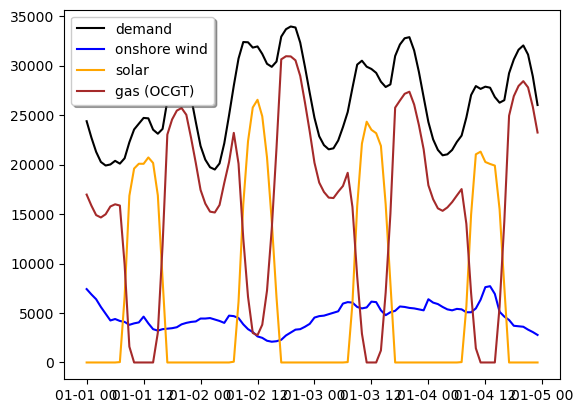

In [33]:
import matplotlib.pyplot as plt

plt.plot(network.loads_t.p['load'][0:96], color='black', label='demand')
plt.plot(network.generators_t.p['onshorewind'][0:96], color='blue', label='onshore wind')
plt.plot(network.generators_t.p['solar'][0:96], color='orange', label='solar')
plt.plot(network.generators_t.p['OCGT'][0:96], color='brown', label='gas (OCGT)')
plt.legend(fancybox=True, shadow=True, loc='best')

Text(0.5, 1.07, 'Electricity mix')

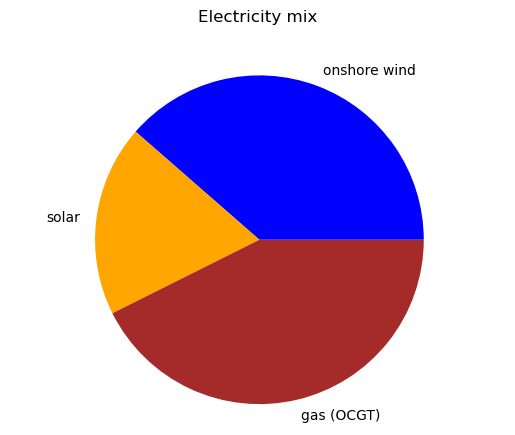

In [34]:
labels = ['onshore wind', 
          'solar', 
          'gas (OCGT)']
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['OCGT'].sum()]

colors=['blue', 'orange', 'brown']

plt.pie(sizes, 
        colors=colors, 
        labels=labels, 
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

We can add a global CO2 constraint and solve again.

In [35]:
co2_limit=4000000 #tonCO2
network.add("GlobalConstraint",
            "co2_limit",
            type="primary_energy",
            carrier_attribute="co2_emissions",
            sense="<=",
            constant=co2_limit)

In [36]:
network.optimize(solver_name='gurobi')

INFO:linopy.model: Solve problem using Gurobi solver
Writing continuous variables.: 100%|██████████████| 2/2 [00:00<00:00,  7.07it/s]


Read LP format model from file /tmp/linopy-problem-n8eoys00.lp
Reading time = 0.37 seconds
obj: 61324 rows, 26283 columns, 109683 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 1 logical processors, using up to 1 threads

Optimize a model with 61324 rows, 26283 columns and 109683 nonzeros
Model fingerprint: 0x30c689aa
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [6e+01, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+06]
Presolve removed 34683 rows and 8400 columns
Presolve time: 0.21s
Presolved: 26641 rows, 17883 columns, 66600 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.1132405e+09   6.183118e+07   0.000000e+00      0s
    3693    1.8097276e+10   1.547710e+06   0.000000e+00      5s
    4595    1.8448556e+10   0.000000e+00   0.000000e+00      6s

Solv

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 26283 primals, 61324 duals
Objective: 1.84e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

In [37]:
network.generators.p_nom_opt #in MW

Generator
onshorewind    190147.670808
solar           32683.511351
OCGT            33249.160559
Name: p_nom_opt, dtype: float64

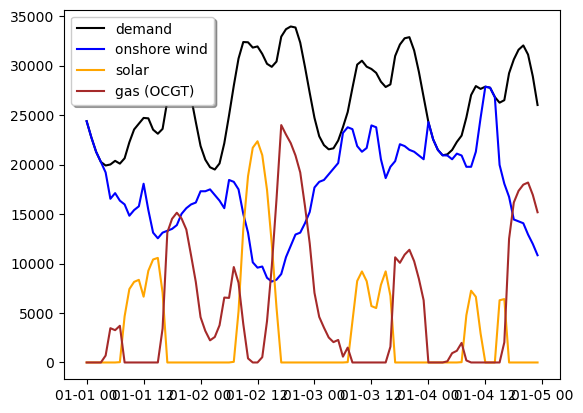

In [38]:
import matplotlib.pyplot as plt

plt.plot(network.loads_t.p['load'][0:96], color='black', label='demand')
plt.plot(network.generators_t.p['onshorewind'][0:96], color='blue', label='onshore wind')
plt.plot(network.generators_t.p['solar'][0:96], color='orange', label='solar')
plt.plot(network.generators_t.p['OCGT'][0:96], color='brown', label='gas (OCGT)')
plt.legend(fancybox=True, shadow=True, loc='best')

Text(0.5, 1.07, 'Electricity mix')

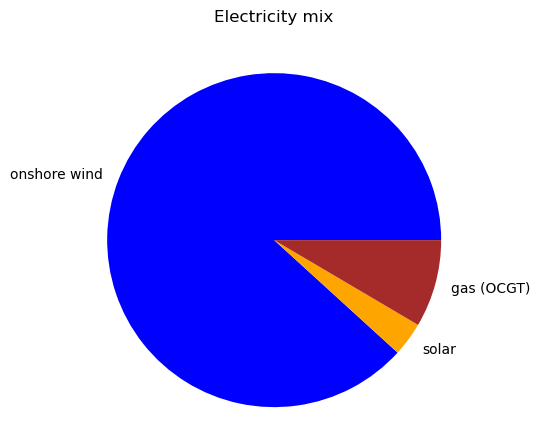

In [39]:
labels = ['onshore wind', 'solar', 'gas (OCGT)' ]
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['OCGT'].sum()]

colors = ['blue', 'orange', 'brown']

plt.pie(sizes, 
        colors=colors, 
        labels=labels, 
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

## PROJECT INSTRUCTIONS

Based on the previous example, you are asked to carry out the following tasks:

A. Choose a different country/region and calculate the optimal capacities for renewable and non-renewable generators. You can add as many technologies as you want. Remember to provide a reference for the cost assumptions. Plot the dispatch time series for a week in summer and winter. Plot the annual electricity mix. Use the duration curves or the capacity factor to investigate the contribution from different technologies. 

B. Investigate how sensitive is the optimum capacity mix to the global CO2 constraint. E.g., plot the generation mix as a function of the CO2 constraint that you impose. Search for the CO2 emissions in your country (today or in 1990) and refer the emissions allowance to that historical data. 

C. Investigate how sensitive are your results to the interannual variability of solar and wind generation. Plot the average capacity and variability obtained for every generator using different weather years. 

D. Add some storage technology/ies and investigate how they behave and what are their impact on the optimal system configuration. 

E. Discuss what strategies is your system using to balance the renewable generation at different time scales (intraday, seasonal, etc.) 

F. Select one target for decarbonization (i.e., one CO2 allowance limit). What is the CO2 price required to achieve that decarbonization level? Search for information on the existing CO2 tax in your country (if any) and discuss your result. 

G. Connect your country with, at least, two neighbour countries. You can assume that the capacities in the neighbours are fixed or cooptimize the whole system. You can also include fixed interconnection capacities or cooptimize them with the generators capacities. Discuss your results.

H. Connect the electricity sector with another sector such as heating or transport, and cooptimize the two sectors. Discuss your results.

I. Finally, select one topic that is under discussion in your region. Design and implement some experiment to obtain relevant information regarding that topic. E.g. 

[-] What are the consequences if Denmark decides not to install more onshore wind? 

[-] Would it be more expensive if France decides to close its nuclear power plants? 

[-] What will be the main impacts of the Viking link?

[-] How does gas scarcity impact the optimal system configuration? 

Write a short report (maximum 10 pages) including your main findings.

# Hints




_TIP 1: You can add a link with the following code_

The efficiency will be 1 if you are connecting two countries and different from one if, for example, you are connecting the electricity bus to the heating bus using a heat pump.
Setting p_min_pu=-1 makes the link reversible.


In [40]:
network.add("Link",
             'country a - country b',
             bus0="electricity bus country a",
             bus1="electricity bus country b",
             p_nom_extendable=True, # capacity is optimised
             p_min_pu=-1,
             length=600, # length (in km) between country a and country b
             capital_cost=400*600) # capital cost * length 


_TIP 2: You can check the KKT multiplier associated with the constraint with the following code_


In [41]:
print(network.global_constraints.constant) #CO2 limit (constant in the constraint)

print(network.global_constraints.mu) #CO2 price (Lagrance multiplier in the constraint)

GlobalConstraint
co2_limit    4000000.0
Name: constant, dtype: float64
GlobalConstraint
co2_limit   -1426.947091
Name: mu, dtype: float64


_TIP 3: You can add a H2 store connected to the electricity bus via an electrolyzer and a fuel cell with the following code_

In [42]:
#Create a new carrier
network.add("Carrier",
      "H2")

#Create a new bus
network.add("Bus",
      "H2",
      carrier = "H2")

#Connect the store to the bus
network.add("Store",
      "H2 Tank",
      bus = "H2",
      e_nom_extendable = True,
      e_cyclic = True,
      capital_cost = annuity(25, 0.07)*57000*(1+0.011))

#Add the link "H2 Electrolysis" that transport energy from the electricity bus (bus0) to the H2 bus (bus1)
#with 80% efficiency
network.add("Link",
      "H2 Electrolysis", 
      bus0 = "electricity bus",
      bus1 = "H2",     
      p_nom_extendable = True,
      efficiency = 0.8,
      capital_cost = annuity(25, 0.07)*600000*(1+0.05))

#Add the link "H2 Fuel Cell" that transports energy from the H2 bus (bus0) to the electricity bus (bus1)
#with 58% efficiency
network.add("Link",
      "H2 Fuel Cell", 
      bus0 = "H2",
      bus1 = "electricity bus",     
      p_nom_extendable = True,
      efficiency = 0.58,
      capital_cost = annuity(10, 0.07)*1300000*(1+0.05)) 



_TIP 4: Multi-node study_

Let's say that you are considering Denmark and want to add Norway and Sweden as neighbors.

Start by creating a new network (same procedure as before):

In [43]:
n = pypsa.Network()
n.set_snapshots(hours_in_2015)
n.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
n.add("Carrier", "onshorewind")
n.add("Carrier", "solar")

Define nodes and coordinates (used for plotting):

In [44]:
nodes = pd.Series(['DNK','NOR','SWE']).values
neighbors =pd.Series(['NOR','SWE']).values
c = list(set(nodes) - set(neighbors))[0]

# longitude
xs = {'DNK':9.732249, 
     'NOR':8.605318,
     'SWE':16.277634}

# latitude
ys = {'DNK':55.990430,
     'NOR':60.978911,
     'SWE':61.357761}

n.add("Bus",'DNK',x=xs['DNK'],y=ys['DNK'])
n.add("Bus",'NOR',x=xs['NOR'],y=ys['NOR'])
n.add("Bus",'SWE',x=xs['SWE'],y=ys['SWE'])

Now, let's add the components (loads, links, generators) using the *'network.madd'* command (instead of *'network.add'*):

Loads:

In [45]:
n.madd("Load",
        nodes, 
        bus=nodes, 
        p_set=df_elec[nodes])

Index(['DNK', 'NOR', 'SWE'], dtype='object')

Links (interconnection):

In [46]:
# Links from main country (c) to neighboring countries
n.madd("Link",
     c + " - " + neighbors,
     bus0=c,
     bus1=neighbors,
     p_nom_extendable=True, # capacity is optimised
     p_min_pu=-1,
     length=600, # length (in km) between country a and country b
     capital_cost=400*600) # capital cost [EUR/MW/km] * length [km] 

# Links between neighboring countries
n.add("Link",
     neighbors[0] + ' - ' + neighbors[1],
     bus0=neighbors[0],
     bus1=neighbors[1],
     p_nom_extendable=True, # capacity is optimised
     p_min_pu=-1,
     length=600, # length (in km) between country a and country b
     capital_cost=400*600) # capital cost [EUR/MW/km] * length [km] 

Create dataframes containing capacity factors for the considered nodes:

In [47]:
CF_wind = pd.DataFrame()
CF_solar = pd.DataFrame()
for i in range(len(nodes)):
    CF_wind[nodes[i]] = df_onshorewind[nodes[i]][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    CF_solar[nodes[i]] = df_solar[nodes[i]][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]

Add generators to each node:

In [48]:
n.madd("Generator",
        nodes + " onshorewind",
        bus=nodes,
        p_nom_extendable=True,
        carrier="onshorewind",
        #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
        capital_cost = capital_cost_onshorewind,
        marginal_cost = 0,
        p_max_pu = CF_wind[nodes].values)

n.madd("Generator",
            nodes + " solar",
            bus=nodes,
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_solar,
            marginal_cost = 0,
            p_max_pu = CF_solar[nodes].values)

n.madd("Generator",
            nodes + " OCGT",
            bus=nodes,
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT)

Index(['DNK OCGT', 'NOR OCGT', 'SWE OCGT'], dtype='object')

Add H2 stores to each node:

In [49]:
n.add("Carrier",
      "H2")

n.madd("Bus",
            nodes + " H2",
            location = nodes,
            carrier = "H2")

n.madd("Store",
             nodes + " H2 Tank",
             bus = nodes + " H2",
             e_nom_extendable = True,
             e_cyclic = True,
             capital_cost = annuity(25, 0.07)*57000*(1+0.011))

n.madd("Link",
      nodes + " H2 Electrolysis", 
      bus0 = nodes,
      bus1 = nodes + " H2",     
      p_nom_extendable = True,
      efficiency = 0.8,
      capital_cost = annuity(25, 0.07)*600000*(1+0.05))

#Add the link "H2 Fuel Cell" that transports energy from the H2 bus (bus0) to the electricity bus (bus1)
#with 58% efficiency
n.madd("Link",
      nodes + " H2 Fuel Cell", 
      bus0 = nodes + " H2",
      bus1 = nodes,     
      p_nom_extendable = True,
      efficiency = 0.58,
      capital_cost = annuity(10, 0.07)*1300000*(1+0.05)) 

Index(['DNK H2 Fuel Cell', 'NOR H2 Fuel Cell', 'SWE H2 Fuel Cell'], dtype='object')

CO2 limit:

In [50]:
co2_limit=0 #tonCO2
n.add("GlobalConstraint",
        "co2_limit",
        type="primary_energy",
        carrier_attribute="co2_emissions",
        sense="<=",
        constant=co2_limit)

Solve the network:

In [ ]:
n.lopf(n.snapshots, 
             pyomo=False,
             solver_name='gurobi')

/tmp/ipykernel_5015/1741158332.py:1: DeprecatedWarning: lopf is deprecated as of 0.24 and will be removed in 1.0. Use linopy-based function ``n.optimize()`` instead. Migrate extra functionalities: https://pypsa.readthedocs.io/en/latest/examples/optimization-with-linopy-migrate-extra-functionalities.html.
  n.lopf(n.snapshots,
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 7.31s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /tmp/pypsa-problem-ddcvjdnh.lp
Reading time = 2.94 seconds
obj: 446761 rows, 210262 columns, 933936 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 1 logical processors, using up to 1 threads

Optimize a model with 446761 rows, 210262 columns and 933936 nonzeros
Model fingerprint: 0xc4448900
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 2e+04]
Presolve removed 248665 rows and 82228 columns
Presolve time: 2.45s
Presolved: 198096 rows, 128034 columns, 705964 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.293832e+08   0.000000e+00      5s
   12996    6.9698979e+09   3.192422e+10   0.000000e+00     10s
   18562    7.0042888e+09   3.647654e+10   0.000000e+00     1

Import plotting function. For this to work with the newest version of PyPSA (v25.2), you need to install the "requests" module (pip install requests)

In [ ]:
from Plotting import plot_map
import warnings
warnings.filterwarnings("ignore")

In [ ]:
tech_colors = {'onshore wind':'blue',
              'solar PV':'orange',
              'gas':'brown',
              'H2':'pink'}

In [ ]:
plot_map(n, tech_colors, threshold=10,components=["generators"], 
             bus_size_factor=5e5, transmission=True)

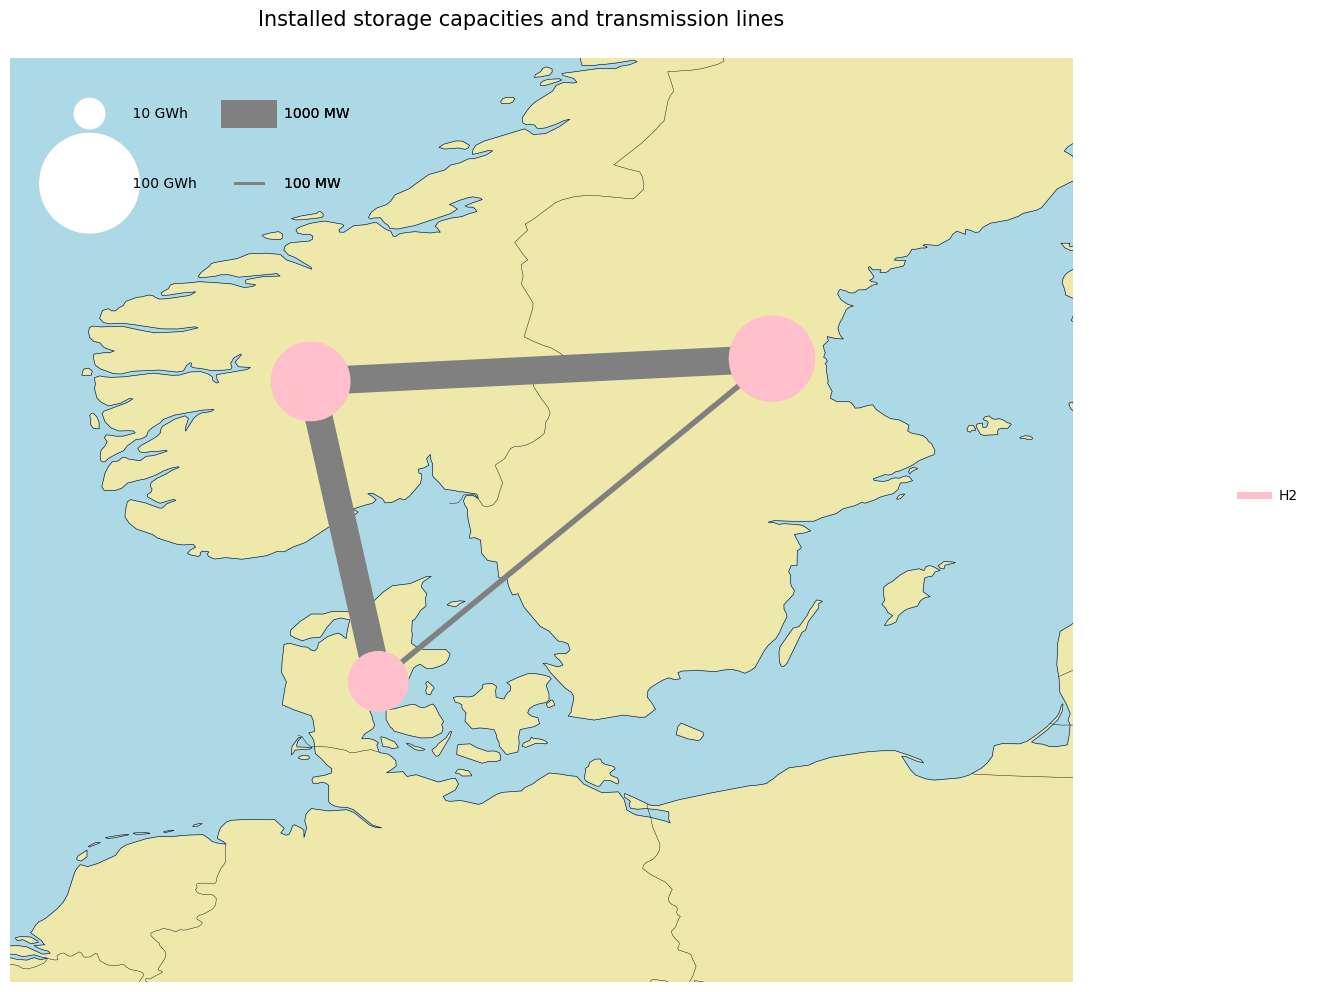

In [35]:
plot_map(n, tech_colors, threshold=10,components=["stores"], 
             bus_size_factor=1e6, transmission=True)